# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

# Acknowledgement

### **Special thanks** to *Ioannis Breier*, a super mentor and *Juan Delgado*, a phenomenal teacher ###

It would not have been possible to complete this course and this final project without your guidance and assistance. Thanks you for the privilege to learn from you, you are simply wonderful !!!


# Start from the next cell below for classifier training
Override default architecture name, learning rate, dropout rate, epochs in the cell *"set args"*

Training in CPU mode is possible but not practical, please run training in GPU mode 

*tip : if utilizing Udacity lab environment, save all your changes prior clicking GPU "Enable/Disble" button to avoid loss of unsaved changes* 

### Start from the cell "Workspace Init" if you want to start with prediction using a saved checkpoint 


In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image

from datetime import datetime
import json
import os
import glob

from workspace_utils import active_session

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
savedir = 'chksav'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])

data_transforms = {'train': transforms.Compose([transforms.RandomRotation(30),
                                                transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                norm]),
                   'valid': transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               norm]),
                   'test': transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               norm])
                  }

# TODO: Load the datasets with ImageFolder
image_datasets = {'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
                  'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
                  'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])} 

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
               'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64, shuffle=True),
               'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=64, shuffle=True)}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
device.type

'cpu'

In [7]:
# set up an arg object to store my stuff
class myArgs(dict):
    pass

args = myArgs()


## set args
set your desired architecture, learning rate, drop out rate, epochs, interval for printing results during training

In [8]:
# set args attributes
args.z_arch = 'densenet121'
args.z_hid = None
args.z_lrate = 0.001
args.z_dpout = 0.3
args.z_epochs = 10
args.z_print = 40

# list all my z_ attributes in args
#print('Args list:\n',[i for i in dir(args) if i.startswith('z_')])

In [9]:
# TODO: Build and train your network
def build_classifier(model, args):
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    
    in_size = {
        'densenet121': 1024,
        'densenet161': 2208,
        'vgg16': 25088,
        }
    
    hid_size = {
        'densenet121': [500],
        'densenet161': [1000, 500],
        'vgg16': [4096, 4096,1000],
        }

    if args.z_dpout:
        p = args.z_dpout
    else:
        p = 0.5
        
    output_size = len(dataloaders['train'].dataset.classes)
    relu = nn.ReLU()
    dropout = nn.Dropout(p)
    output = nn.LogSoftmax(dim=1)
    
    if args.z_hid:
        h_list = args.z_hid.split(',')
        h_list = list(map(int, h_list)) # convert list from string to int
    else:
        h_list = hid_size[args.z_arch]
        
    h_layers = [nn.Linear(in_size[args.z_arch], h_list[0])]
    h_layers.append(relu)
    if args.z_arch[:3] == 'vgg':
        h_layers.append(dropout)
        
    if len(h_list) > 1:
        h_sz = zip(h_list[:-1], h_list[1:])
        for h1,h2 in h_sz:
            h_layers.append(nn.Linear(h1, h2))
            h_layers.append(relu)
            if args.z_arch[:3] == 'vgg':
                h_layers.append(dropout)
                
    last = nn.Linear(h_list[-1], output_size)    
    h_layers.append(last)
    h_layers.append(output)

    print(h_layers)
    model.classifier = nn.Sequential(*h_layers)
    
    return model

In [10]:
# Build a classifier

# load a pre-trained model and override with own classifier
model = models.__dict__[args.z_arch](pretrained=True)    
model = build_classifier(model, args)
print('\nmodel architecture:', args.z_arch, '\n')
model.classifier

[Linear(in_features=1024, out_features=500, bias=True), ReLU(), Linear(in_features=500, out_features=102, bias=True), LogSoftmax(dim=1)]

model architecture: densenet121 



/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=1024, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=102, bias=True)
  (3): LogSoftmax(dim=1)
)

In [11]:
def validate(model, dataloaders, criterion):
    valid_loss = 0
    accuracy = 0
    
    for images, labels in iter(dataloaders['valid']):
        images, labels = images.to(device), labels.to(device)
        
        output = model.forward(images)
        valid_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return valid_loss, accuracy

In [12]:
# training
def train(model, dataloaders, optimizer, criterion, epochs=2, print_freq=20, lr=0.001):
    if torch.cuda.is_available():
        print('*** training classifier in GPU mode ...\n')
    else:
        print('*** training classifier in CPU mode ...\n')

    model.to(device)
    start_time = datetime.now()
    
    print('epochs:', epochs, ', print_freq:', print_freq, ', lr:', lr, '\n')

    steps = 0
    

    for e in range(epochs):
        model.train()
        running_loss = 0
        for images, labels in iter(dataloaders['train']):
            steps +=1

            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_freq == 0:
                model.eval()
                
                with torch.no_grad():
                    valid_loss, accuracy = validate(model, dataloaders, criterion)

                print('Epoch: {}/{}..'.format(e+1, epochs),
                      'Training Loss: {:.3f}..'.format(running_loss/print_freq),
                      'Validation Loss: {:.3f}..'.format(valid_loss/len(dataloaders['valid'])),
                      'Validation Accuracy: {:.3f}%'.format(accuracy/len(dataloaders['valid']) * 100)
                     )
                running_loss = 0

                model.train()
        
    elapsed = datetime.now() - start_time
    
    print('\n*** classifier training done ! \nElapsed time[hh:mm:ss.ms]: {}'.format(elapsed))
    
    return model

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [14]:
# TODO: Do validation on the test set
def test(model, dataloaders, criterion):
    print('*** validating testset ...\n')
    model.cpu()
    model.eval()
    
    test_loss = 0
    total = 0
    match = 0
    
    start_time = datetime.now()
    
    with torch.no_grad():
        for images, labels in iter(dataloaders['test']):
            model, images, labels = model.to(device), images.to(device), labels.to(device)
                    
            output = model.forward(images)
            test_loss += criterion(output, labels).item()
            total += images.shape[0]
            equality = labels.data == torch.max(output, 1)[1]
            match += equality.sum().item()
    
    model.test_accuracy = match/total * 100        
    print('Test Loss: {:.3f}'.format(test_loss/len(dataloaders['test'])),
          'Test Accuracy: {:.2f}%'.format(model.test_accuracy))
    
    elapsed = datetime.now() - start_time
    print('\n*** test validation done ! \nElapsed time[hh:mm:ss.ms]: {}'.format(elapsed))

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [15]:
# TODO: Save the checkpoint 
model = model.cpu() # back to CPU mode post training 
model.class_to_idx = dataloaders['train'].dataset.class_to_idx

checkpoint = {'arch': args.z_arch,
              'classifier': model.classifier,
              'epochs': args.z_epochs,
              'dropout': args.z_dpout,
              'lrate': args.z_lrate,
              'train_sz': dataloaders['train'].batch_size,
              'valid_sz': dataloaders['valid'].batch_size,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'class_to_idx' : model.class_to_idx
             }

if not os.path.isdir(savedir):
        os.makedirs(savedir)
        
chkpt = datetime.now().strftime('%Y%m%d_%H%M%S') + '_' + args.z_arch + '.pth'
checkpt = os.path.join(savedir, chkpt)

torch.save(checkpoint, checkpt)
print('*** checkpoint: ', chkpt,  ', saved to: ', os.path.dirname(checkpt))

*** checkpoint:  20231114_094446_densenet121.pth , saved to:  chksav


## Workspace Init 

If there has been a switch from a GPU to CPU workspace on Udacity lab platform or 
if you start with prediction using a saved checkpoint without executing cells from the top to run training first, then
### start from the next cell below to run prediction with a saved checkpoint 

In [16]:
# Initialize workspace 

try:
    args
except NameError:  
    # re-import required packages
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'

    import matplotlib.pyplot as plt

    import torch
    import numpy as np
    from torch import nn
    from torch import optim
    import torch.nn.functional as F
    from torchvision import datasets, transforms, models
    from PIL import Image

    from datetime import datetime
    import json
    import os
    import glob

    from workspace_utils import active_session
    
    # set up required file directories
    data_dir = 'flowers'
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'
    test_dir = data_dir + '/test'
    savedir = 'chksav'
    
    # re-define your transforms for the training, validation, and testing sets
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])

    data_transforms = {'train': transforms.Compose([transforms.RandomRotation(30),
                                                    transforms.RandomResizedCrop(224),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor(),
                                                    normalize]),
                       'valid': transforms.Compose([transforms.Resize(256),
                                                   transforms.CenterCrop(224),
                                                   transforms.ToTensor(),
                                                   normalize]),
                       'test': transforms.Compose([transforms.Resize(256),
                                                   transforms.CenterCrop(224),
                                                   transforms.ToTensor(),
                                                   normalize])
                      }

    image_datasets = {'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
                      'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
                      'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])} 

    dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
                   'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64, shuffle=True),
                   'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=64, shuffle=True)}
    
    # re-load json class name mapper
    with open('cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)
    
    # set device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('device type:', device.type)
    
    # Re-instantiate args after exiting GPU mode
    class myArgs(dict):
        pass

    print('re-instantiate args...')
    args = myArgs()
    
    # get the last saved checkpoint
    if len(glob.glob(savedir+'/*.pth')) > 0 :
        checkpt = max(glob.glob(savedir+'/*.pth'), key=os.path.getctime)
        print('checkpoint:', checkpt, ' successfully loaded')
    else:
        checkpt = None
        print('\n*** no saved checkpoint to load !!!\n')
    



## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [17]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):

    # if no longer in GPU, force all tensors to be on CPU 
    if device.type == 'cpu':
        checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)        
    else:
        checkpoint = torch.load(filepath)
        
    
    model = models.__dict__[checkpoint['arch']](pretrained=True)
    model.classifier = checkpoint['classifier']
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    
    args.z_arch = checkpoint['arch']
    
    return model, args

In [18]:
# load checkpoint

if checkpt: 
    model, args = load_checkpoint(checkpt)
    # check results
    print('model architecture:', args.z_arch, '\n')
    print('model.classifier:\n', model.classifier)
else:
    print('\n*** stop !!! no saved checkpoint to load \n')

# list all my z_ attributes in args 
#print('Args list:\n',[i for i in dir(args) if i.startswith('z_')])

model architecture: densenet121 

model.classifier:
 Sequential(
  (0): Linear(in_features=1024, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=102, bias=True)
  (3): LogSoftmax(dim=1)
)


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [19]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
   
    pil_img=image
    
    sz = image.size 
    h = min(image.size)
    w = max(image.size)
    #print('size:',sz, ', h:',h, ', w:',w)
    
    # calculate ratio_aspect using original height & width
    # chosen h is 256, ratio aspect for adjusted w is original w/h
    ratio_aspect = w/h
    
    # get indices of short and long sides
    x = image.size.index(min(image.size))
    y = image.size.index(max(image.size))
    
    # calc new size with short side 256 pixels keeping ratio aspect
    new_sz = [0, 0]
    new_sz[x] = 256
    new_sz[y] = int(new_sz[x] * ratio_aspect)
    
    #print('new_sz:',new_sz, '\npre resized img:', pil_img)
    
    # resize base on short side of 256 pixels
    pil_img=image.resize(new_sz)
    #print('post resized image:', pil_img)
    
    # crop out the center 224x224 portion 
    wid, hgt = new_sz
    #print('wid:', wid, ', hgt:', hgt)
    
    # calc left, top, right, bottom margin pos
    l_margin = (wid - 224)/2
    t_margin = (hgt - 224)/2
    r_margin = (wid + 224 )/2
    b_margin = (hgt + 224)/2
    
    #print('left:',l_margin, ', top:',t_margin, ', right:',r_margin, ', bottom:',b_margin)
    
    # crop the image
    pil_img=pil_img.crop((l_margin, t_margin, r_margin, b_margin))
    #print('cropped img:', pil_img)
    
    # convert to np array for normalization purpose 
    np_img = np.array(pil_img)
    
    print('np_img.shape',np_img.shape)

    np_img = np_img/255    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_img = (np_img - mean)/std
    
    # transpose to get color channel to 1st pos
    np_img = np_img.transpose((2, 0, 1))
    
    return np_img    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [20]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [21]:
# confingure args to randomly select an image file, its class and path
def pick_a_pic(dset_dir, dset_type, args):
    args.z_imgcls = np.random.choice(dataloaders[dset_type].dataset.classes)
    args.z_rndimg = np.random.choice(os.listdir(dset_dir + '/' + args.z_imgcls))
    args.z_rndimgpth = dset_dir + '/' + args.z_imgcls + '/' + args.z_rndimg
    return args

In [22]:
# pick an image from test set
args = pick_a_pic(test_dir,'test', args)

print('class:', args.z_imgcls,', image:', args.z_rndimg, '\npath:', args.z_rndimgpth,'\n')
print('args parameters:\n',[i for i in dir(args) if i.startswith('z_')], '\n')

class: 17 , image: image_03906.jpg 
path: flowers/test/17/image_03906.jpg 

args parameters:
 ['z_arch', 'z_dpout', 'z_epochs', 'z_hid', 'z_imgcls', 'z_lrate', 'z_print', 'z_rndimg', 'z_rndimgpth'] 



np_img.shape (224, 224, 3)


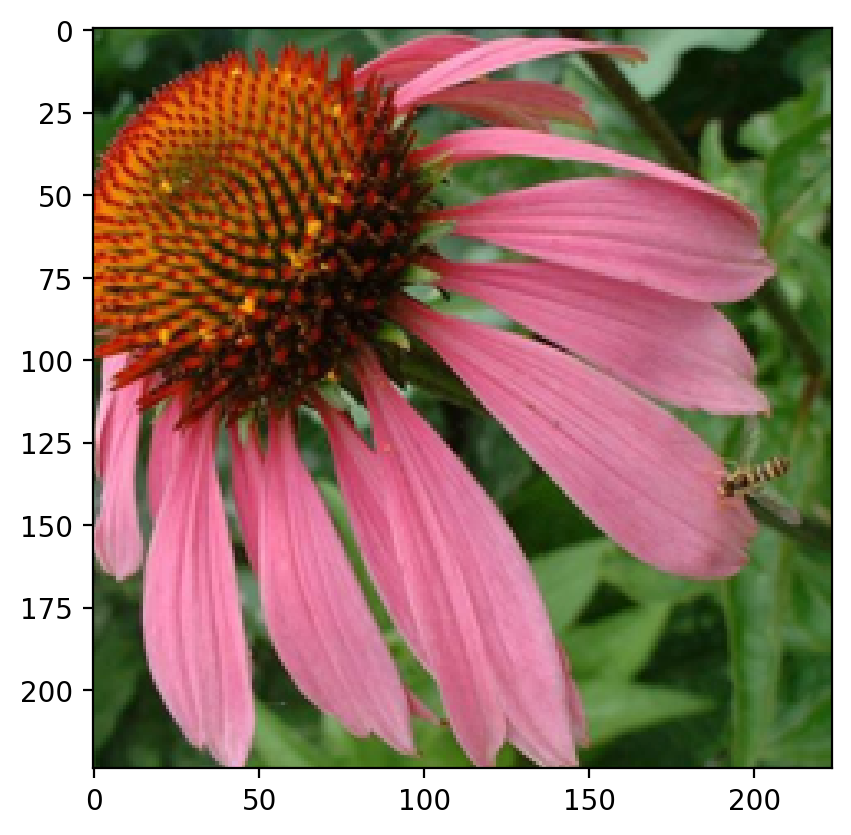

In [23]:
# Pass a pic from test set to image_process to convert into torch FloatTensor
with Image.open(args.z_rndimgpth) as image:
    np_img = process_image(image)
    imshow(np_img)

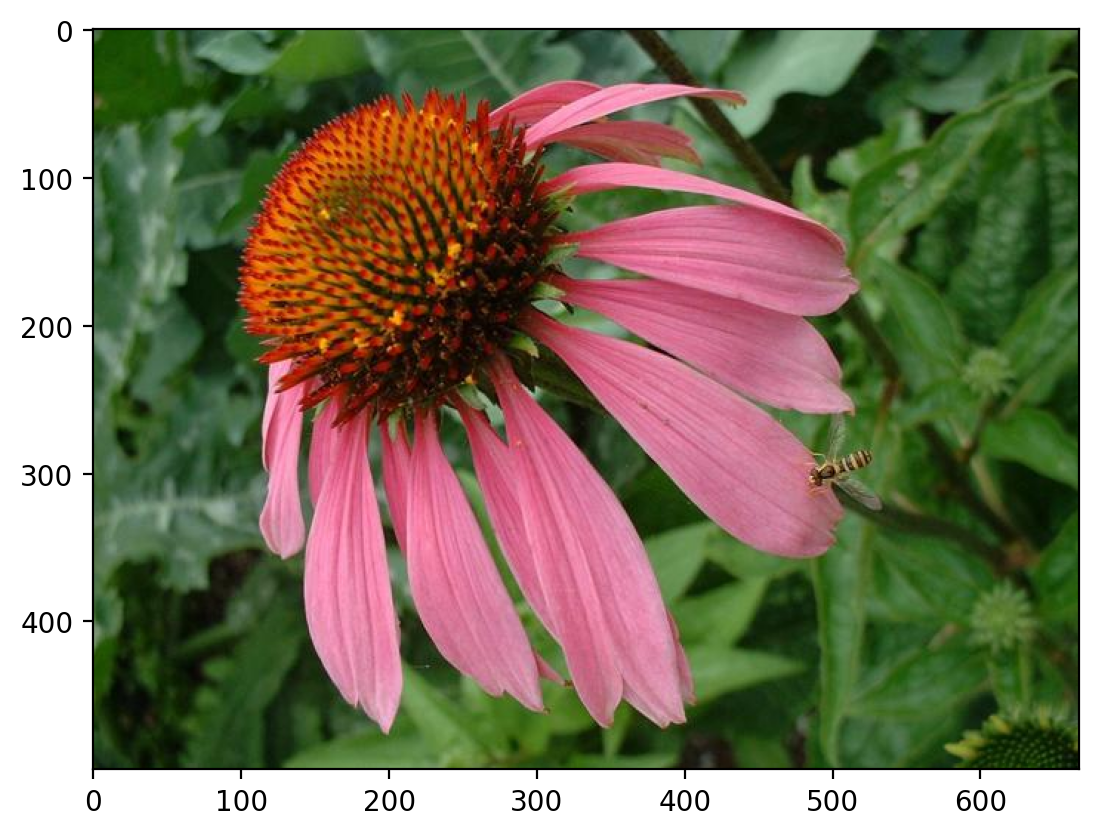

In [24]:
# Restore image to original config
with Image.open(args.z_rndimgpth) as image:
    plt.imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [25]:
def predict(image_path, cat_to_name, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.cpu()
    model.eval()
    
    pil_img = Image.open(image_path)
    image = process_image(pil_img)
    image = torch.FloatTensor(image)
        
    model, image = model.to(device), image.to(device)
        
    print('\nori image.shape:', image.shape)
    image.unsqueeze_(0) # add a new dimension in pos 0
    print('new image.shape:', image.shape, '\n')
        
    output = model.forward(image)
        
    # get the top k classes of prob
    ps = torch.exp(output).data[0]
    topk_prob, topk_idx = ps.topk(topk)

    # bring back to cpu and convert to numpy
    topk_probs = topk_prob.cpu().numpy()
    topk_idxs = topk_idx.cpu().numpy()

    # map topk_idx to classes in model.class_to_idx
    idx_class={i: k for k, i in model.class_to_idx.items()}
    topk_classes = [idx_class[i] for i in topk_idxs]

    # map class to class name
    topk_names = [cat_to_name[i] for i in topk_classes] 
    
    print('*** Top ', topk, ' classes ***')
    print('class names:   ', topk_names)
    print('classes:       ', topk_classes)
    print('probabilities: ', topk_probs)
    
    return topk_classes, topk_names, topk_probs

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [26]:
# TODO: Display an image along with the top 5 classes
def show_classifier(model, imgcls, imgpth, cat_to_name):
    
    topk_classes, topk_names, topk_probs = predict(imgpth, cat_to_name, model)

    img = Image.open(imgpth)
    
    # get img name
    img_name = cat_to_name[imgcls]
    
    fig, (ax1, ax2) = plt.subplots(figsize=(10,4), ncols=2)
    ax1.set_title(img_name)
    ax1.imshow(img)
    ax1.axis('off')

    y_pos = np.arange(len(topk_probs))
    ax2.barh(y_pos, topk_probs)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(topk_names)
    ax2.invert_yaxis()
    ax2.set_xlim(0, 1.1)
    ax2.set_title('Class Probability')
    
    plt.tight_layout()
    plt.show()

image path: flowers/test/37/image_03741.jpg 

np_img.shape (224, 224, 3)

ori image.shape: torch.Size([3, 224, 224])
new image.shape: torch.Size([1, 3, 224, 224]) 

*** Top  5  classes ***
class names:    ['hibiscus', 'ruby-lipped cattleya', 'poinsettia', 'great masterwort', 'garden phlox']
classes:        ['83', '36', '44', '38', '32']
probabilities:  [0.01592304 0.01396628 0.01341947 0.01324051 0.01303584]


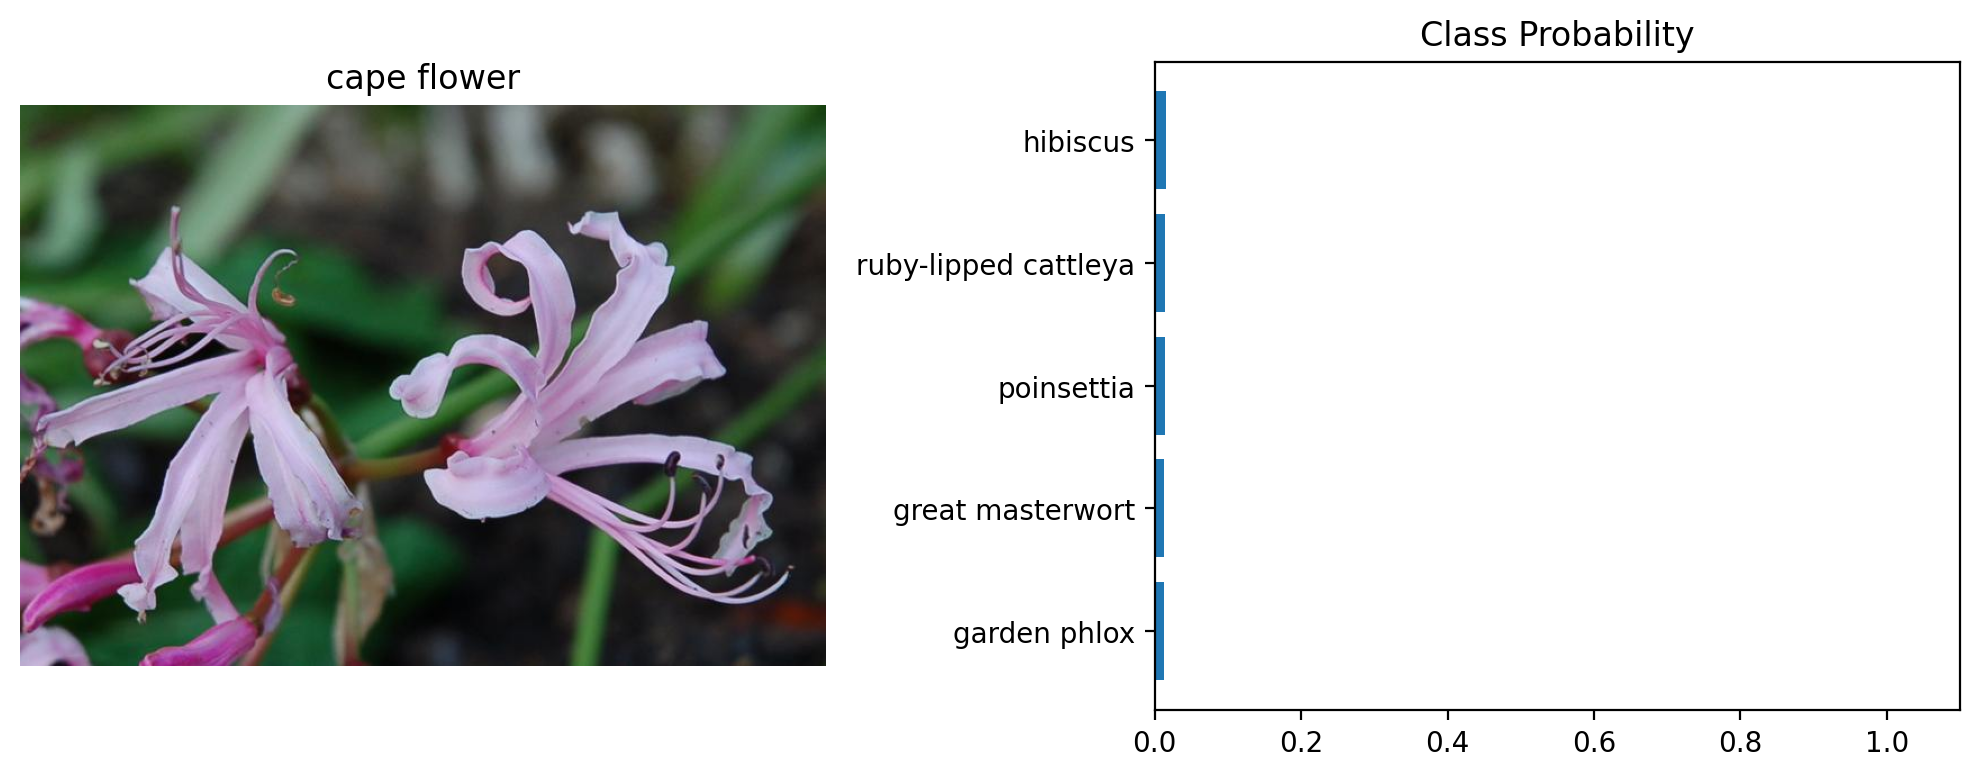

In [27]:
# display a randomly selected image with its top 5 classes probabilities
args = pick_a_pic(test_dir,'test', args)
print('image path:', args.z_rndimgpth, '\n')
show_classifier(model, args.z_imgcls, args.z_rndimgpth, cat_to_name)